# Exploratory Data Analysis of Fantasy Football Kickers
#### Matthew Johnson, Aug. 8, 2018 (Last updated: August 13, 2018)
##### Data source: https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016

1. **NFL Data**
2. Vegas odds
3. Weather

$KickerPts = 1 *(Made PAT) + 3*(FG_{d\leq 39}) + 4*(FG_{d\in [40,49]}) + 5*(FG_{d\geq 50}) - 1*(Missed FG)$

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### The general idea of what is being implemented:

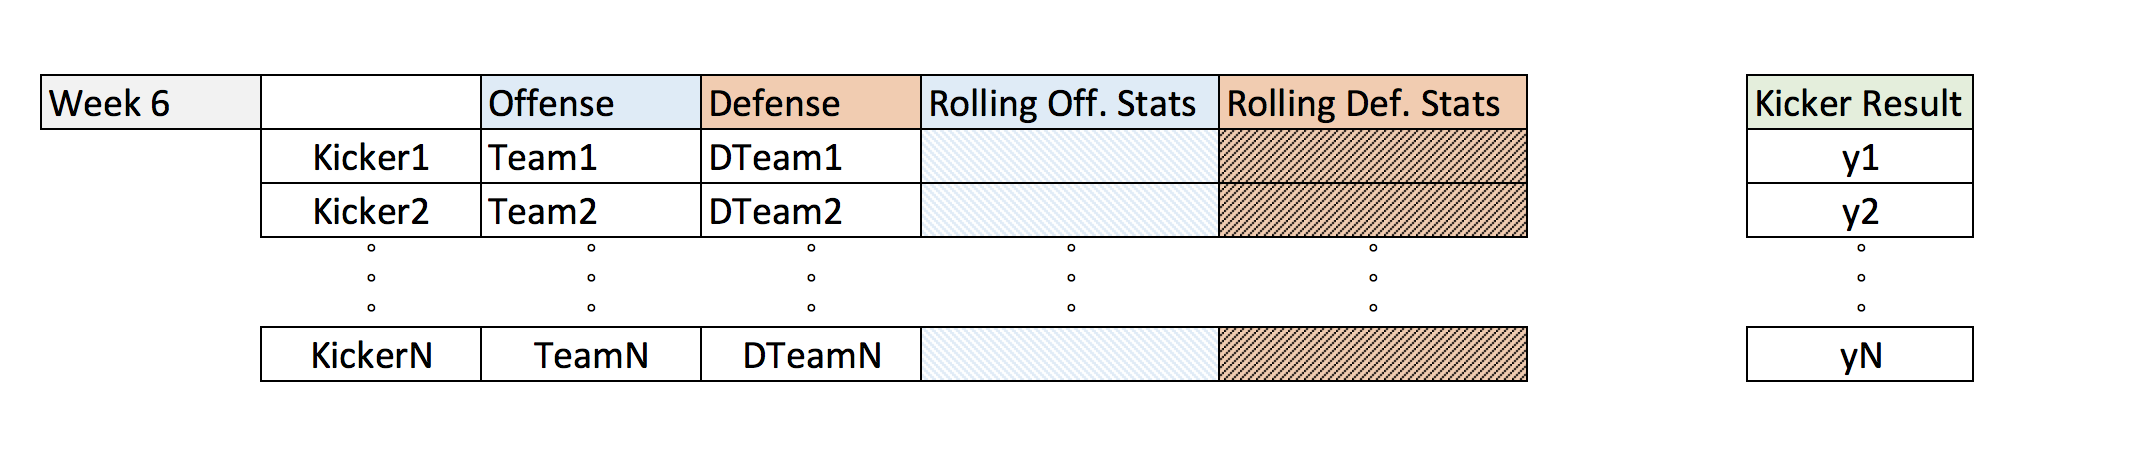

In [7]:
from IPython.display import Image
Image(filename='/Users/mattjohnson/Desktop/Python2018/NFL/Screen Shot 2018-08-08 at 2.19.03 PM.png') 

In [8]:
def add_features(nfl_data):

    data = nfl_data.copy()
    data = data.drop(['Unnamed: 0'], axis=1)

    # get the number of missing data points per column
    missing_values_count = data.isnull().sum()

    data['ExPointGood'] = np.where(data['ExPointResult'] == 'Made', 1, 0 )
    data['ExPointBad'] = np.where((data['ExPointResult'] == 'Missed') | (data['ExPointResult'] == 'Blocked'), 1, 0 )

    data['FieldGoalGood'] = np.where(data['FieldGoalResult'] == 'Good', 1, 0 )
    data['FieldGoalBad'] = np.where((data['FieldGoalResult'] == 'No Good') | (data['ExPointResult'] == 'Blocked'), 1, 0 )

    data['TwoPointGood'] = np.where(data['TwoPointConv'] == 'Success', 1, 0 )
    data['TwoPointConv'] = np.where((data['TwoPointConv'] == 'Success') | (data['TwoPointConv'] == 'Failure'), 1, 0 )

    data['CompletePass'] = np.where(data['PassOutcome'] == 'Success', 1, 0 )
    data['IncompletePass'] = np.where(data['PassOutcome'] == 'Incomplete Pass', 1, 0 )
    
    data['FG_30'] = np.where((data['FieldGoalDistance']>0) & (data['FieldGoalDistance']<40), 1, 0)
    data['FG_40'] = np.where((data['FieldGoalDistance']>=40) & (data['FieldGoalDistance']<=50), 1, 0)
    data['FG_50'] = np.where((data['FieldGoalDistance']>=50), 1, 0)

    data.drop(['ExPointResult', 'FieldGoalResult', 'PassOutcome', 'FieldGoalDistance'], axis=1, inplace=True)
    
    return data

In [9]:
# Returns an acronym for opposing team given a team and gameId
def get_opposing_team(data, offenseTeam, gameId):
    teams = data[ data['GameID']==gameId]['posteam'].dropna().unique()
    if teams[0] == offenseTeam: 
        return teams[1]
    else:
        return teams[0]

In [10]:
def create_mask(df, start_date, end_date):
    if end_date == 0:
        end_date = start_date + pd.to_timedelta(7,unit='d')
    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    return df.loc[mask]

def sort_by_week(data):
    # sort by week
    data['Date'] = pd.to_datetime(data['Date'])
    mondays = list(data.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')['Date'].values)
    mondays.append(0)

    week_list = []
    data['Week'] = 0

    for i in range(0,len(mondays)-1):
        current_week = create_mask(data, mondays[i], mondays[i+1])
        current_week['Week'] = i+1
        week_list.append(current_week)

    week_data = pd.concat(week_list)
    week_data.reset_index(drop=True).head()
    dummied_data = pd.concat([week_data.drop('PlayType', axis=1), pd.get_dummies(week_data['PlayType']) ], axis=1)
    dummied_data['drive'] = dummied_data['Drive'].copy()
    dummied_data['gameid'] = dummied_data['GameID'].copy()
    
    return dummied_data

In [11]:
vals = ['Touchdown','ExPointGood', 'ExPointBad', 'FieldGoalGood', 'FieldGoalBad', 'TwoPointGood', 'TwoPointConv', 'CompletePass', 
        'IncompletePass', 'Yards.Gained', 'FG_30', 'FG_40', 'FG_50', 'yrdline100', 'Punt', 'QB Kneel', 'Drive', 'Week', 'gameid',
       'FirstDown', 'down']
aggs = {'Touchdown': np.sum,'ExPointGood':np.sum, 'ExPointBad':np.sum, 'FieldGoalGood': np.sum, 
        'FieldGoalBad':np.sum, 'TwoPointGood':np.sum, 'TwoPointConv':np.sum, 'CompletePass':np.sum, 
        'IncompletePass':np.sum, 'Yards.Gained':np.sum, 'FG_30':np.sum, 'FG_40':np.sum, 'FG_50':np.sum,
        'yrdline100': max, 'Punt':np.sum, 'QB Kneel':np.sum, 'Drive': max, 'Week': max, 'gameid': max,
       'FirstDown':np.sum, 'down' : max}

vals2 = ['Touchdown','ExPointGood', 'ExPointBad', 'FieldGoalGood', 'FieldGoalBad', 'TwoPointGood', 'TwoPointConv', 'CompletePass', 
        'IncompletePass', 'Yards.Gained', 'FG_30', 'FG_40', 'FG_50','PointsScored', 'Week','gameid',
        'Kicker_Pts',  'FG_range', 'RedZone', 'Punt', 'QB Kneel', 'Drive', '3rdDown', '3rdDownSuccess','FirstDown']
aggs2 = {'Touchdown': np.sum,'ExPointGood':np.sum, 'ExPointBad':np.sum, 'FieldGoalGood': np.sum, 
        'FieldGoalBad':np.sum, 'TwoPointGood':np.sum, 'TwoPointConv':np.sum, 'CompletePass':np.sum, 
        'IncompletePass':np.sum, 'Yards.Gained':np.sum, 'FG_30':np.sum, 'FG_40':np.sum, 'FG_50':np.sum,
        'FG_range': np.sum, 'RedZone':np.sum,'PointsScored': np.sum, 'Punt':np.sum, 'QB Kneel':np.sum, 
         'Drive': max, 'Kicker_Pts':np.sum, '3rdDown': np.sum, '3rdDownSuccess':np.sum, 'Week': max, 'gameid': max,
        'FirstDown':np.sum, }

dropVals_off = ['CompletePass','ExPointBad', 'ExPointGood', 'FG_30', 'FG_40',
       'FG_50', 'FG_range', 'FieldGoalBad', 'FieldGoalGood', 'IncompletePass', 'PointsScored', 'Punt', 'QB Kneel', 'RedZone',
       'Touchdown', 'TwoPointGood','Yards.Gained', 'Week_rolling5',
        'gameid_rolling5']
dropVals_def = ['DEF_CompletePass','DEF_ExPointBad', 'DEF_ExPointGood',
       'DEF_FG_30', 'DEF_FG_40', 'DEF_FG_50', 'DEF_FG_range', 'DEF_Kicker_Pts',
       'DEF_FieldGoalBad', 'DEF_FieldGoalGood', 'DEF_IncompletePass', 'DEF_PointsScored', 'DEF_Punt', 'DEF_QB Kneel',
       'DEF_RedZone', 'DEF_Touchdown', 'DEF_TwoPointConv', 'DEF_TwoPointGood', 
        'DEF_3rdDown',  'DEF_Drive', 'DEF_3rdDown', 'DEF_gameid',  
        'DEF_QB Kneel_rolling5', 'DEF_gameid_rolling5']

In [12]:
def make_pivot_tables(dummied_data):
    pivot = pd.pivot_table(dummied_data.reset_index(drop=True), index=["posteam", "GameID", "DefensiveTeam", 'drive'], 
                       values = vals, aggfunc=aggs )

    pivot['PointsScored'] = 6*pivot['Touchdown'] + pivot['ExPointGood'] +  3*pivot['FieldGoalGood'] + 2*pivot['TwoPointGood'] 
    
    pivot['Kicker_Pts'] = pivot['ExPointGood'] + 3*pivot['FG_30'] + 4*pivot['FG_40'] + 5*pivot['FG_50'] - 1*pivot['FieldGoalBad']
    pivot['FG_range'] = 1*(pivot['yrdline100']>=60)
    pivot['RedZone'] = 1*(pivot['yrdline100']>=80)
    pivot['3rdDown'] = 1*(pivot['down']==3.0)
    pivot['3rdDownSuccess'] = 1*(pivot['down']==3.0)*(pivot['FirstDown']==1.0)

    pivot_weekly = pd.pivot_table(pivot, index=["posteam", "GameID", "DefensiveTeam"], values = vals2, aggfunc=aggs2)

    pivot_def = pd.pivot_table(pivot, index=["DefensiveTeam", "GameID"], values = vals2, aggfunc=aggs2)

    new_cols = []
    for col in pivot_def.columns:
        new_cols.append('DEF_'+ col)
    pivot_def.columns = new_cols
    
    return pivot, pivot_weekly, pivot_def

In [24]:

def add_rolling(pivot_weekly, pivot_def, N):
    #piv_list_O = []
    #piv_list_D = []
    firstPass = True
    
    pivotO = pivot_weekly.copy()
    pivotD = pivot_def.copy()

    for n in N:
        

        for val in pivot_weekly.columns:
            pivotO[val+'_rolling'+str(n)] = 0

        for idx in pivotO.index.levels[0]:
            for val in pivot_weekly.columns:
                pivotO[val+'_rolling'+str(n)][idx] = pivotO[val][idx].rolling(n).mean()
        

        for val in pivot_def.columns:
            pivotD[val+'_rolling'+str(n)] = 0

        for idx in pivotD.index.levels[0]:
            for val in pivot_def.columns:
                pivotD[val+'_rolling'+str(n)][idx] = pivotD[val][idx].rolling(n).mean()
                
        try:    
            pivotO.drop(dropVals_off, axis=1, inplace=True)
        except:
            a=1
        pivotO = pivotO[ pivotO['Week']<1000]
        pivotO = pivotO[ pivotO['CompletePass_rolling'+str(n)]>-1] 
        try:
            pivotD.drop(dropVals_def, axis=1, inplace=True)
        except:
            a=1
        pivotD = pivotD[ pivotD['DEF_Week']<1000]
        pivotD = pivotD[ pivotD['DEF_CompletePass_rolling'+str(n)]>-1]
    
        if firstPass:
            k = ''
            firstPass=False
        else: 
            k=str(n)
        
        pivotO['FG_range_per_drive'+k] = pivotO['FG_range_rolling'+str(n)]/pivotO['Drive_rolling'+str(n)]
        pivotO['RZ_per_drive'+k] = pivotO['RedZone_rolling'+str(n)]/pivotO['Drive_rolling'+str(n)]
        pivotD['DEF_FG_range_per_drive'+k] = pivotD['DEF_FG_range_rolling'+str(n)]/pivotD['DEF_Drive_rolling'+str(n)]
        pivotD['DEF_RZ_per_drive'+k] = pivotD['DEF_RedZone_rolling'+str(n)]/pivotD['DEF_Drive_rolling'+str(n)]

        #piv_list_O.append(pivotO)
        #piv_list_D.append(pivotD)
        
    #pivotOff = pd.concat(piv_list_O, axis=1) 
    #pivotDef = pd.concat(piv_list_D, axis=1)
    return pivotO, pivotD

In [14]:
def get_train_row(data, pivot_off, pivot_def, offTeam, gameID):
    defTeam = get_opposing_team(data, offTeam, gameID)
    defense_df = pivot_def.loc[(defTeam,gameID)]
    offense_df = pivot_off.loc[(offTeam,gameID)]

    tempdf = pd.concat([offense_df.reset_index(drop=True), pd.DataFrame(defense_df).T.reset_index(drop=True)], axis=1)
    tempdf['offenseTeam'] = offTeam
    tempdf['defenseTeam'] = defTeam
    tempdf.index = tempdf['offenseTeam']+ '-' + str(gameID)
    
    return tempdf 

In [15]:
def make_train_data(data, pivot_off, pivot_def): 
    train_list = []
    
    for week in range(6,17):
        week_off = pivot_off[ pivot_off['Week']==week]
        week_def = pivot_def[ pivot_def['DEF_Week']==week]
  
        for offTeam in week_off.index.levels[0]:
            for gameid in week_off.loc[offTeam]['gameid'].unique():
                train_list.append(get_train_row(data, pivot_off, pivot_def, offTeam, gameid))     

    train_df = pd.concat(train_list)
    return train_df

def save_train_data(dataframe, year):
    dataframe.to_csv('fantasy_kickers' + str(year) + '.csv')

In [25]:
def make_annual_dfs(year_start, year_after_end):
    annual_dfs = []
    for year in range(year_start, year_after_end):
        nfldata = pd.read_csv('/Users/mattjohnson/Desktop/Python2018/NFL/data2/NFL bySeason/NFL_data_' + str(year)+'.csv')
        df = add_features(nfldata)
        df = sort_by_week(df)
        pivot_drives, pivot_weekly, pivot_def = make_pivot_tables(df)
        pivot_off, pivot_def = add_rolling(pivot_weekly, pivot_def, [5])
        train = make_train_data(df, pivot_off, pivot_def)
        train['Season'] = year
        #save_train_data(train, year)
        annual_dfs.append(train)
        
    return finish_up_df(pd.concat(annual_dfs))

In [17]:
def finish_up_df(X):
    X['punts_per_drive'] = X['Punt_rolling5']/X['Drive_rolling5']
    X['DEF_punts_per_drive'] = X['DEF_Punt_rolling5']/X['DEF_Drive_rolling5']
    X.drop(['DEF_ExPointBad_rolling5', 'DEF_FG_30_rolling5', 'DEF_FG_40_rolling5', 'DEF_Week', 
            'DEF_Week_rolling5','DEF_FG_50_rolling5', 'DEF_FieldGoalBad_rolling5', 'DEF_Punt_rolling5',
            'DEF_TwoPointConv_rolling5', 'DEF_TwoPointGood_rolling5'], axis=1, inplace=True)
    X['gameid'] = X['gameid'].astype(str)
    X['date'] = (X['gameid'].str[4:6] + '/' + X['gameid'].str[6:8]).str.lstrip('0')
    X['offenseTeam']= X['offenseTeam'].str[0:4].str.strip('-')
    X['offenseTeam']= X['offenseTeam'].str.rstrip('-2')
    X['Season'] = X['Season'].astype(str)
    X['mergeCode'] = X['Season'] + '-' + X['date'] +'-'+ X['offenseTeam']
    X['mergeCode2'] = X['Season']+'-'+ X['Week'].astype(str)+'-' + X['offenseTeam']
    X['3rdDown_rate'] = X['3rdDownSuccess_rolling5']/X['3rdDown_rolling5']
    
    # these currently not working 
    # CompletePass_rolling5 is 0s
    X['Completion_pct'] = X['CompletePass_rolling5']/(X['CompletePass_rolling5']+X['IncompletePass_rolling5'])
    X['DEF_Completion_pct'] = X['DEF_CompletePass_rolling5']/(X['DEF_CompletePass_rolling5']+X['DEF_IncompletePass_rolling5'])
    X['TwoPoint_conv_rate'] = X['TwoPointGood_rolling5']/X['TwoPointConv_rolling5']

    return X

## Start Here

In [38]:
data09_17 = make_annual_dfs(2009, 2017)

In [26]:
data2011 = make_annual_dfs(2011,2012)

In [39]:
data09_17.to_csv('kicker_data_09_17.csv')

In [43]:
corrmat = pd.DataFrame(data09_17.corr()['Kicker_Pts'])
corrmat.sort_values('Kicker_Pts', ascending=False)[2:12]

,Kicker_Pts
DEF_Kicker_Pts_rolling5,0.466118
DEF_FieldGoalGood_rolling5,0.352015
FieldGoalGood_rolling5,0.346328
FG_40_rolling5,0.229683
DEF_Yards.Gained,0.229642
FG_30_rolling5,0.205683
DEF_PointsScored_rolling5,0.194375
PointsScored_rolling5,0.182112
FG_50_rolling5,0.120468
DEF_Yards.Gained_rolling5,0.116418


In [44]:
X = data09_17.drop('Kicker_Pts', axis=1)
y = data09_17['Kicker_Pts']

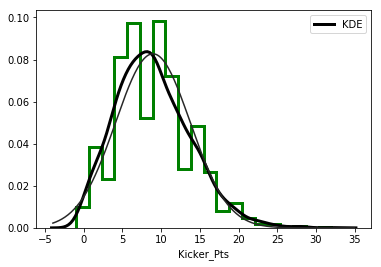

In [50]:
from scipy.stats import norm

sns.distplot(y, bins=20, fit=norm,
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"});